# Práctica 5 : Regresión lineal regularizada, sesgo y varianza

Mario Quiñones y Guillermo García Patiño

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
import scipy.optimize as opt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler, MinMaxScaler

## Regresión Lineal Regularizada

En esta parte se va a buscar el parámetro de regularización óptimo para una regresión lineal

In [6]:
#########
# MUY IMPORTANTE HACER RAVEL PARA PASAR DE (12,) a (12). SI USAS (12,) HACE BROADCASTING
########

def cargaDatos(file = 'ex5data1.mat'):
    m = loadmat(file)
    x_train = m['X']
    y_train = m['y'].ravel()
    x_test = m['Xtest']
    y_test = m['ytest'].ravel()
    x_val = m['Xval']
    y_val = m['yval'].ravel()
    train = [x_train, y_train]
    test = [x_test, y_test]
    val = [x_val, y_val]
    return train, test, val

Función para calcular el coste de la regresión lineal teniendo en cuenta el parámetro de regularización de manera vectorizada

In [7]:
def coste_reg(T, X, Y, Lambda):
    coef1 = (1/(2* X.shape[0]))
    
    H = np.dot(X,T)
    D = H - Y
    sumErs = np.sum(D**2)
    
    coef2 = (Lambda/(2*X.shape[0]))
    reg = (T[1:]**2).sum()
    
    coste = ( coef1 * sumErs ) + ( coef2 * reg )
    return coste

Esta función calcula el gradiente de la regresión lineal regularizada de manera vectorizada

In [8]:
def gradiente_reg(T, X, Y, Lambda):
    H = np.dot(X,T)
    D = H - Y
    G = np.dot(X.T, D)
    G = G / X.shape[0]
    G[1:] += (T[1:] * (Lambda / X.shape[0]))
    return G

In [9]:
def main1():
    tr, te, vl = cargaDatos()
    X = tr[0]
    Y = tr[1].ravel()
    m = X.shape[0]
    X = np.hstack([np.ones( [m, 1 ] ) , X ] )
    T = np.ones((X.shape[1],))
    grad = gradiente_reg(T,X,Y,1)
    c = coste_reg(T,X,Y,1)
    print(c)
    print(grad)

In [10]:
main1()

303.9931922202643
[-15.30301567 598.25074417]


Esta función calcula el coste y el gradiente para los ejemplos de entrenamiento X,Y dados un vector de parámetros Theta y un parámetro de regularización Lambda

En esta función, antes de calcular el coste y el gradiente, acumulamos un 1 en la matriz X

In [11]:
def costeygradienteReg(Theta,X,Y,Lambda):

    Xaux = np.hstack([np.ones((X.shape[0], 1)), X])
    coste = coste_reg(Theta,Xaux,Y,Lambda)
    gradiente = gradiente_reg(Theta,Xaux,Y,Lambda)
    return coste,gradiente

Usamos esta función para obtener el vector Theta de parámetros óptimos entrenando con los ejemplos X,Y y usando el parámetro de regularización Lambda.

En esta ocasión, tenemos que crear el vector T con una componente más que columnas tiene X porque estamos haciendo regresión lineal de 1 variable, así que X no tiene la columna de 1 que necesitamos.

In [12]:
def optimizar(X,Y,Lambda):
    T = np.ones((X.shape[1]+1,1))
    result = opt.minimize(costeygradienteReg,T,args=(X,Y,Lambda),method='TNC',jac=True)['x']
    return result

In [13]:
def main2():
    tr, te, vl = cargaDatos()
    X = tr[0]
    Y = tr[1]
    r = optimizar(X,Y,0)
    print(r)

In [14]:
main2()

[13.08790348  0.36777923]


In [15]:
def pintarDatos():
    tr, te, vl = cargaDatos()
    X = tr[0]
    Y = tr[1]
    r = optimizar(X,Y,0)
    
    plt.figure()
    plt.plot(X,Y,"x")
    min_x = min(X)
    max_x = max(X)
    min_y = r[0] + r[1] * min_x
    max_y = r[0] + r[1] * max_x
    plt.plot([min_x, max_x], [min_y, max_y])
    plt.savefig("resultado.pdf")

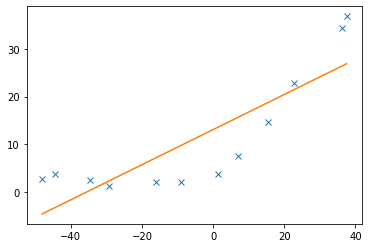

In [16]:
pintarDatos()

## Curvas de Aprendizaje

Ahora pintamos la curva de aprendizaje, que representa el error del modelo respecto al conjunto de entrenamiento y al de validación frente al número de ejemplos de entrenamiento con las que se entrena el modelo

Esta función devuelve el coste y el gradiente de los ejemplos X,Y en función de un vector de parámeros Theta y un parámetro de regularización Lambda

In [13]:
def costeygradienteReg2(Theta,X,Y,Lambda):
    coste = coste_reg(Theta,X,Y,Lambda)
    gradiente = gradiente_reg(Theta,X,Y,Lambda)
    return coste,gradiente

Esta funcion encuentra los parámetros óptimos Theta de un polinomio de grado 8 (así que Theta tiene 9 componentes). Asumimos que la matriz de atributos X viene ya normalizada y con la columna de 1 necesaria

In [14]:
def optimizar2(X,Y,Lambda):
    T = np.ones((X.shape[1],)).ravel()
    result = opt.minimize(costeygradienteReg2,T,args=(X,Y,Lambda),method='TNC',jac=True)['x']
    return result

In [15]:
def curvaAprendizaje():
    tr,te,vl = cargaDatos()
    X = tr[0]
    Y = tr[1]
    
    Xval = vl[0]
    Xval = np.hstack([np.ones((Xval.shape[0], 1)), Xval])
    Yval = vl[1]
    
    erroresT = np.zeros((X.shape[0],))
    erroresV = np.zeros((X.shape[0],))
    ejeX = np.zeros((X.shape[0],))
    for j in range(1,X.shape[0]):
        ejeX[j] = j
        Xaux = X[0:j]
        Yaux = Y[0:j]
        Xaux = np.hstack([np.ones((j, 1)), Xaux])
        r = optimizar2(Xaux,Yaux,0)
        
        erroresT[j] += coste_reg(r,Xaux,Yaux,0)
        erroresV[j] += coste_reg(r,Xval,Yval,0)
    
    plt.figure()
    plt.plot(ejeX[1:], erroresT[1:], 'b', label = "Entrenamiento")
    plt.plot(ejeX[1:], erroresV[1:], 'r', label = "Validacion")
    plt.xlabel("Numero de ejemplos de entrenamiento")
    plt.ylabel("Error")
    plt.legend(loc = 0)
    plt.show()

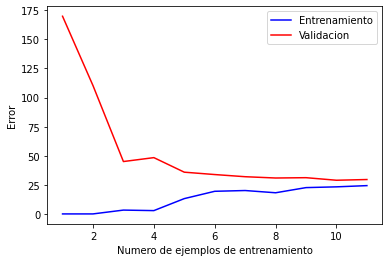

In [16]:
curvaAprendizaje()

## Regresion Polinomial

Esta función transforma la matriz de ejemplos de entrenamiento X en una matriz que contiene los mismos ejemplos pero representados como un vector de g+1 componentes. Además, el resultado de esta función devuelve ya la matriz con la columna de 1 necesaria

In [17]:
def generaPolinomio(X,g):
    p = PolynomialFeatures(g)
    X2 = p.fit_transform(X)
    return X2

Esta función normaliza los atributos de los ejemplos que vienen en X como (Valor Atributo - Media de atributo)/(desv tipica de atributo)

Si a esta función le llega una matriz X con todo 1 en un atributo, fallará porque la desviación típica será 0. Hay que pasarle la matriz X sin la columna de unos

In [18]:
def normalizar(X):
    mu = np.mean(X, axis=0)
    sigma = np.std(X, axis=0)
    X_norm = (X-mu)/sigma
    return(X_norm, mu, sigma)

In [19]:
def main3():
    tr,te,vl = cargaDatos()
    X = tr[0]
    Y = tr[1]
    Xpol = generaPolinomio(X,8)
    Xpoln , mu, sigma = normalizar(Xpol[:, 1:])
    ones = np.ones((Xpoln.shape[0],1))
    Xpoln = np.hstack([ones, Xpoln])
    
    T = optimizar2(Xpoln, Y, 0)
    
    Xvalues = np.arange(X.min()-10 , X.max()+10, 0.05)
    # Para pasar de 1D array a 2D array. Lo hago porque salia un error que me decía que lo hiciera
    Xvalues = Xvalues.reshape(-1, 1)
    Xpolvalues = generaPolinomio(Xvalues,8)
    Xpolnvalues = (Xpolvalues[:,1:] - mu) / sigma
    ones2 = np.ones((Xpolnvalues.shape[0], 1))
    Xpolnvalues = np.hstack([ones2, Xpolnvalues])
    
    Ypolvalues  = np.dot(Xpolnvalues,T)
    
    ax=plt.gca()
    ax.axis([X.min()-5,X.max()+5,Y.min()-10,Y.max()+5])
    plt.plot(X,Y, "x", color = 'red')
    plt.plot(Xvalues, Ypolvalues, '-b')

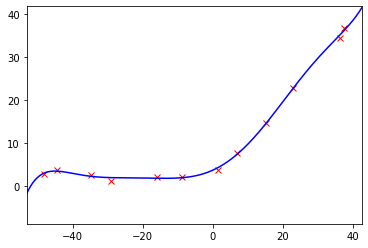

In [20]:
main3()

Esta función hace lo mismo que `normalizar` , pero lo hace usando el StandardScaler de la librería de SKLearn. Puede recibir la matriz X con una columna de unos sin dar error.
A la matriz resultado Y hay que sumarle 1 a la columna de unos original (la primera de la matriz X) porque devuelve todo 0 en esa columna.

Además de la matriz normalizada, la media de cada atributo y la varianza de cada atributo, devuelve un objeto Scaler que permite transformar cualquier matriz de individuos con los mismos atributos empleando la media y la desviación típica de los atributos de la matriz X

In [21]:
def normalizar2(X):
    scaler = StandardScaler()
    scaler.fit(X)
    mu = scaler.mean_
    sigma = scaler.scale_
    Y = scaler.transform(X)
    return Y,mu,sigma,scaler

In [24]:
def main4():
    tr,te,vl = cargaDatos()
    X = tr[0]
    Y = tr[1]
    Xpol = generaPolinomio(X,8)
    Xpoln , mu, sigma, scaler = normalizar2(Xpol[:, 1:])
    ones = np.ones((Xpoln.shape[0],1))
    Xpoln = np.hstack([ones, Xpoln])
    
    T = optimizar2(Xpoln, Y, 0)
    
    Xvalues = np.arange(X.min()-5 , X.max()+5, 0.05)
    # Para pasar de 1D array a 2D array. Lo hago porque salia un error que me decía que lo hiciera
    Xvalues = Xvalues.reshape(-1, 1)
    Xpolvalues = generaPolinomio(Xvalues,8)
    Xpolnvalues = (Xpolvalues[:,1:] - mu) / sigma
    ones2 = np.ones((Xpolnvalues.shape[0], 1))
    Xpolnvalues = np.hstack([ones2, Xpolnvalues])
    
    Ypolvalues  = np.dot(Xpolnvalues,T)
    
    ax=plt.gca()
    ax.axis([X.min()-5,X.max()+5,Y.min()-10,Y.max()+5])
    plt.plot(X,Y, "x", color = 'red')
    plt.plot(Xvalues, Ypolvalues, '-b')

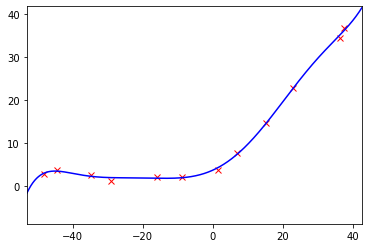

In [25]:
main4()

## Curvas de Aprendizaje

In [26]:
def generaPolinomio(X,g):
    p = PolynomialFeatures(g)
    X2 = p.fit_transform(X)
    return X2

In [27]:
def error(T,X,Y):
    coef1 = (1/(2* X.shape[0]))
    
    H = np.dot(X,T)
    D = H - Y
    sumErs = np.sum(D**2)
    
    
    coste = ( coef1 * sumErs ) 
    return coste

In [28]:
def curvaAprendizaje3(Lambda):
    tr, test, val = cargaDatos()
    
    X = tr[0]
    Y = tr[1]
    
    Xval = val[0]
    Yval = val[1]
    
    print(X.shape)
    print(Xval.shape)
    
    X = generaPolinomio(X,8)
    Xval = generaPolinomio(Xval,8)
    
    X,mu,sigma,scaler = normalizar2(X)
    X[:,0] += 1
    
    Xval = scaler.transform(Xval)
    Xval[:,0] += 1
    
    ejeX = np.arange(1, X.shape[0], 1)
    errorT = np.zeros(X.shape[0]-1)
    errorV = np.zeros(X.shape[0]-1)
    
    for j in range(1, X.shape[0]):
        X2 = X[0:j, :]
        Y2 = Y[0:j]
        
        r = optimizar2(X2,Y2,Lambda)
        errorT[j-1] = error(r,X2,Y2)
        errorV[j-1] = error(r,Xval,Yval)
        
        print("Lambda = {} / ErrorTest = {} / Ejemplos = {}".format(Lambda, errorT[j-1], j))
        
    plt.plot(ejeX,errorT, 'b' , label = "Entrenamiento")
    plt.plot(ejeX,errorV, 'r' , label = "Validacion")

(12, 1)
(21, 1)
Lambda = 0 / ErrorTest = 9.860761315262648e-32 / Ejemplos = 1
Lambda = 0 / ErrorTest = 3.614957723972272e-17 / Ejemplos = 2
Lambda = 0 / ErrorTest = 6.180470289913674e-17 / Ejemplos = 3
Lambda = 0 / ErrorTest = 1.6229978943794782e-14 / Ejemplos = 4
Lambda = 0 / ErrorTest = 3.44680823971721e-12 / Ejemplos = 5
Lambda = 0 / ErrorTest = 2.9501088416128532e-08 / Ejemplos = 6
Lambda = 0 / ErrorTest = 2.4066828739233664e-09 / Ejemplos = 7
Lambda = 0 / ErrorTest = 0.002277468508696026 / Ejemplos = 8
Lambda = 0 / ErrorTest = 0.03028860691812678 / Ejemplos = 9
Lambda = 0 / ErrorTest = 0.041446299240215236 / Ejemplos = 10
Lambda = 0 / ErrorTest = 0.04016867974065798 / Ejemplos = 11


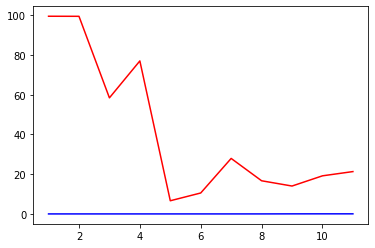

In [29]:
curvaAprendizaje3(0)

(12, 1)
(21, 1)
Lambda = 1 / ErrorTest = 9.652860155508887e-20 / Ejemplos = 1
Lambda = 1 / ErrorTest = 0.04283839571442041 / Ejemplos = 2
Lambda = 1 / ErrorTest = 2.515218098478268 / Ejemplos = 3
Lambda = 1 / ErrorTest = 1.2855385892834161 / Ejemplos = 4
Lambda = 1 / ErrorTest = 1.0283195338427427 / Ejemplos = 5
Lambda = 1 / ErrorTest = 0.7949296141866686 / Ejemplos = 6
Lambda = 1 / ErrorTest = 1.4099632054754583 / Ejemplos = 7
Lambda = 1 / ErrorTest = 1.3162421434907814 / Ejemplos = 8
Lambda = 1 / ErrorTest = 1.4587331507678858 / Ejemplos = 9
Lambda = 1 / ErrorTest = 1.353285738666421 / Ejemplos = 10
Lambda = 1 / ErrorTest = 1.2285353041180487 / Ejemplos = 11


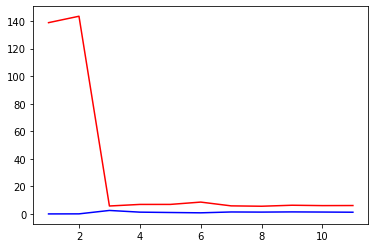

In [30]:
curvaAprendizaje3(1)

(12, 1)
(21, 1)
Lambda = 100 / ErrorTest = 1.245554392697584e-19 / Ejemplos = 1
Lambda = 100 / ErrorTest = 0.11398554005804466 / Ejemplos = 2
Lambda = 100 / ErrorTest = 105.9591535982427 / Ejemplos = 3
Lambda = 100 / ErrorTest = 119.94526589383578 / Ejemplos = 4
Lambda = 100 / ErrorTest = 100.88640927011795 / Ejemplos = 5
Lambda = 100 / ErrorTest = 95.25749280151047 / Ejemplos = 6
Lambda = 100 / ErrorTest = 81.68810254212481 / Ejemplos = 7
Lambda = 100 / ErrorTest = 74.88456528714954 / Ejemplos = 8
Lambda = 100 / ErrorTest = 69.81950885138086 / Ejemplos = 9
Lambda = 100 / ErrorTest = 62.96404522010895 / Ejemplos = 10
Lambda = 100 / ErrorTest = 57.73168893123231 / Ejemplos = 11


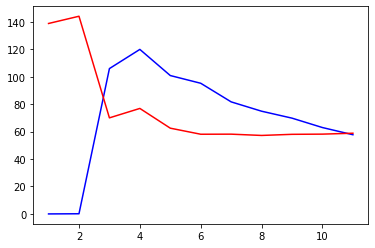

In [31]:
curvaAprendizaje3(100)

(12, 1)
(21, 1)
Lambda = 10 / ErrorTest = 2.1617928596070678e-20 / Ejemplos = 1
Lambda = 10 / ErrorTest = 0.10194965900333114 / Ejemplos = 2
Lambda = 10 / ErrorTest = 46.8239944266395 / Ejemplos = 3
Lambda = 10 / ErrorTest = 37.068102533595166 / Ejemplos = 4
Lambda = 10 / ErrorTest = 28.932747262488434 / Ejemplos = 5
Lambda = 10 / ErrorTest = 24.90592337549245 / Ejemplos = 6
Lambda = 10 / ErrorTest = 21.869143875044013 / Ejemplos = 7
Lambda = 10 / ErrorTest = 18.72987367339912 / Ejemplos = 8
Lambda = 10 / ErrorTest = 17.29490961863615 / Ejemplos = 9
Lambda = 10 / ErrorTest = 15.540216234315759 / Ejemplos = 10
Lambda = 10 / ErrorTest = 14.09253368849591 / Ejemplos = 11


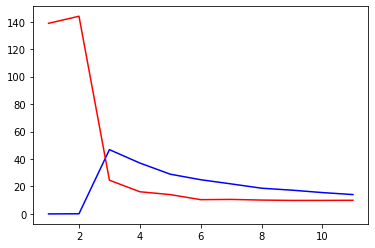

In [32]:
curvaAprendizaje3(10)

## Selección del Parámetro λ

In [33]:
def pruebaLambdas2(Lambdas):
    tr, test, val = cargaDatos()
    
    X = tr[0]
    Y = tr[1]
    
    Xval = val[0]
    Yval = val[1]
    
    print(X.shape)
    print(Xval.shape)
    
    X = generaPolinomio(X,8)
    X,mu,sigma, scaler = normalizar2(X)
    X[:,0] += 1
    
    print(X.shape)
    
    Xval = generaPolinomio(Xval,8)
    Xval = scaler.transform(Xval)
    Xval[:,0]+=1
    
    errorT = np.zeros(Lambdas.shape[0])
    errorV = np.zeros(Lambdas.shape[0])
    
    for j in range(Lambdas.shape[0]):
        
        r = optimizar2(X,Y,Lambdas[j])
        errorT[j] = coste_reg(r,X,Y,Lambdas[j])
        errorV[j] = coste_reg(r,Xval,Yval,Lambdas[j])
        
        print("Lambda = {} / ErrorTest = {} / ErrorVal = {}".format(Lambdas[j],errorT[j],errorV[j]))
        
    return errorT, errorV

In [34]:
def graficarErrorLambdas():
    Lambdas = np.array([0,0.001,0.003,0.01,0.03,0.1,0.3,1,3,10])
    errorT, errorV = pruebaLambdas2(Lambdas)
    ax = plt.gca()
    plt.plot(Lambdas, errorT, 'b', label = 'Entrenamiento')
    plt.plot(Lambdas, errorV, 'r', label = 'Validacion')
    print(errorT)
    print(errorV)
    
    m = np.argmin(abs(errorT - errorV))
    print("Lamda optima = {}".format(Lambdas[m]))
    print("Error de entrenamiento para lambda = 1 es {}".format(errorT[m]))

(12, 1)
(21, 1)
(12, 9)
Lambda = 0.0 / ErrorTest = 0.09352528044009785 / ErrorVal = 8.479039304392241
Lambda = 0.001 / ErrorTest = 0.1695957410695278 / ErrorVal = 9.756124600659573
Lambda = 0.003 / ErrorTest = 0.24320909076313443 / ErrorVal = 16.155245403163693
Lambda = 0.01 / ErrorTest = 0.3712830091273028 / ErrorVal = 17.237711000768677
Lambda = 0.03 / ErrorTest = 0.636702939209546 / ErrorVal = 13.427237542219414
Lambda = 0.1 / ErrorTest = 1.3605722579625361 / ErrorVal = 8.453076524492513
Lambda = 0.3 / ErrorTest = 2.9176493462841746 / ErrorVal = 5.9318822118129315
Lambda = 1.0 / ErrorTest = 6.830463317219911 / ErrorVal = 7.047227793587933
Lambda = 3.0 / ErrorTest = 14.937645805918022 / ErrorVal = 9.782199380996552
Lambda = 10.0 / ErrorTest = 31.878154019266574 / ErrorVal = 18.633911727362104
[ 0.09352528  0.16959574  0.24320909  0.37128301  0.63670294  1.36057226
  2.91764935  6.83046332 14.93764581 31.87815402]
[ 8.4790393   9.7561246  16.1552454  17.237711   13.42723754  8.4530765

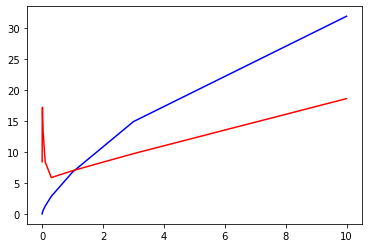

In [35]:
graficarErrorLambdas()

In [45]:
tr, test, val = cargaDatos()
    
X = tr[0]
Y = tr[1]
    
Xt = test[0]
Yt = test[1]
    
print(X.shape)
print(Xt.shape)
    
X = generaPolinomio(X,8)
X,mu,sigma, scaler = normalizar2(X)
X[:,0] += 1
    
print(X.shape)
    
Xt = generaPolinomio(Xt,8)
Xt = scaler.transform(Xt)
Xt[:,0]+=1
    
r = optimizar2(X,Y,1)

ctrain = coste_reg(r,X,Y,1)
ctest = coste_reg(r,Xt,Yt,1)

print("Error de test para lambda = 1 es {}".format(ctest))

(12, 1)
(21, 1)
(12, 9)
Error de test para lambda = 1 es 5.563878556656672
